In [1]:
import torch
import copy
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F
 
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_dataset = datasets.MNIST(root='C:/Users/WorkStation/Desktop/Git_Repositories/Dataset', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root='C:/Users/WorkStation/Desktop/Git_Repositories/Dataset', train = False, transform = transforms.ToTensor(), download = True)

C:\Users\WorkStation\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
def list_np_tensor(param_data):
    data = []
    for i in range(np.size(param_data, 0)):
        data.append(np.concatenate((param_data[i]['net.0.weight'].cpu().numpy(), np.expand_dims(param_data[i]['net.0.bias'].cpu().numpy(), axis=1)),axis=1))
    
    data = torch.Tensor(data)
    return data
    
def save_param(param_data):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    dtf = pd.DataFrame(dt)
    dtf.to_csv(f"FL(mining_data)/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def add_round(param_data, round_list, args):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    
    round_tensor = torch.tensor(round_list).view(-1, 1)
    dt_r = torch.cat((dt, round_tensor), dim=1)
    return dt_r

def save_param_for_mining(param_tensor, args):
    dtf = pd.DataFrame(param_tensor)
    dtf.to_csv(f"FL(mining_data)/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def load_data(args):    
    ldt = pd.read_csv(f"FL(mining_data)/parameter_data/param_data_{args.num_clients}.csv")
    ldt = ldt.values
    ldt = np.delete(ldt, 0, 1)
    return ldt

def data_split(args):
    dataset_list=[]

    num_data_arr = np.ones((args.num_clients,), dtype=int) * int(len(train_dataset)/args.num_clients)
    dataset_list = torch.utils.data.random_split(train_dataset, num_data_arr)
    return dataset_list

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Linear(28*28, 10)
                                )

    def forward(self, x):
        x = x.view(-1,28*28)
        out = self.net(x)
        return out

In [5]:
def define_client(partition, r, num, args):
    train_loader = DataLoader(partition['train'][num], batch_size=args.batch_size, shuffle=True)
    
    if r == 0:
        net = Net().to(device)
    else:
        net = torch.load(args.INIT_PATH)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)

    return net, train_loader, criterion, optimizer

In [6]:
def train(net, train_loader, criterion, optimizer, args):

    for epoch in range(args.num_epochs):        
        for images, labels in iter(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad() 
            
            outputs = net(images)  
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

    torch.save(net, args.NET_PATH)
    return net

In [7]:
def Fed_AVG(model, client_model_list, args):
    model.train()
    local_weights = []

    for i in range(args.num_clients):
        local_weights.append(copy.deepcopy(client_model_list[i].state_dict()))
    w_avg = copy.deepcopy(local_weights[0]) #type of w_avg : <class 'collections.OrderedDict'>

    for key in w_avg.keys():
        for i in range(1,len(local_weights)):
            w_avg[key] += local_weights[i][key]

        w_avg[key] = torch.div(w_avg[key], len(local_weights))

    global_weights = w_avg
    model.load_state_dict(global_weights)
    torch.save(model, args.INIT_PATH)

    return model, local_weights

In [8]:
def test(model, partition, criterion, args):
    test_loader = DataLoader(partition['test'], batch_size=args.batch_size, shuffle=True)
    model.eval()
        
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    loss = 0
    round_accuracy = 0
    round_loss = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    
    round_loss = loss / len(test_loader)
    round_accuracy = (correct / total) * 100.0
    
    return round_loss, round_accuracy

In [9]:
def plot_loss(round_loss, round_acc):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1,2,1)
    plt.plot(round_loss, label = 'Loss')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(round_acc, label = 'Accuracy')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.show()

In [10]:
def experiment(partition, args):
    model = Net().to(device)
    torch.save(model, args.INIT_PATH)

    round_losses = []
    round_acces = []
    param_data = []
    round_list = []

    for r in range(args.num_rounds):
        client_model_list = []
        
        for num in range(args.num_clients):
            if args.exp_name == 'mining':
                setattr(args, 'NET_PATH', f'FL(mining_data)/client_{num}.pth')
            else:
                setattr(args, 'NET_PATH', f'FL_model/client = {args.num_clients}/client_{num}.pth')
            
            net, train_loader, criterion, optimizer = define_client(partition, r, num, args)
            net = train(net, train_loader, criterion, optimizer, args)
            client_model_list.append(net)

        model, local_weights = Fed_AVG(model, client_model_list, args)
        round_loss, round_acc = test(model, partition, criterion, args)

        if r%100 == 0 or r==(args.num_rounds-1):
            print(f'[Round {r}]  Round Loss: {round_loss}  Round Acc: {round_acc:.2f}')

        round_losses.append(round_loss)
        round_acces.append(round_acc)
        round_list.append([r, r, r])
        param_data += local_weights
        
    return round_losses, round_acces, round_list, param_data

# ===== seed = 1228 ===== #
[Round 0]  Round Loss: 0.7766053175926209  Round Acc: 84.96
[Round 100]  Round Loss: 0.2630053900927305  Round Acc: 92.82
[Round 200]  Round Loss: 0.2698613403737545  Round Acc: 92.92
[Round 300]  Round Loss: 0.27760546617209914  Round Acc: 92.89
[Round 400]  Round Loss: 0.28480591617524625  Round Acc: 92.90
[Round 499]  Round Loss: 0.29114479281008243  Round Acc: 92.88


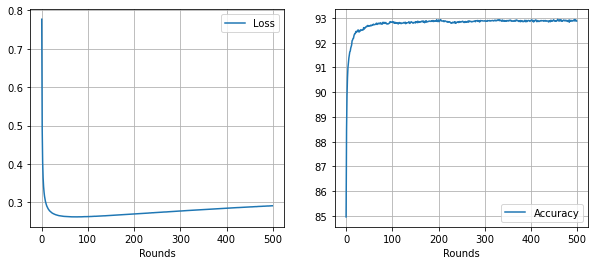

# ===== seed = 2456 ===== #
[Round 0]  Round Loss: 0.7799595308303833  Round Acc: 85.03
[Round 100]  Round Loss: 0.26305260993540286  Round Acc: 92.84
[Round 200]  Round Loss: 0.2700997293740511  Round Acc: 92.72
[Round 300]  Round Loss: 0.27796504341065886  Round Acc: 92.80
[Round 400]  Round Loss: 0.28509811230003834  Round Acc: 92.90
[Round 499]  Round Loss: 0.29151249781250954  Round Acc: 92.85


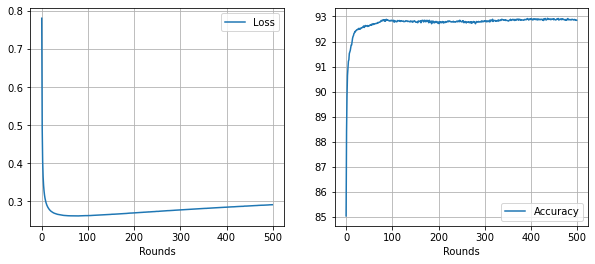

# ===== seed = 3684 ===== #
[Round 0]  Round Loss: 0.7764494025707245  Round Acc: 85.24
[Round 100]  Round Loss: 0.26290770776569844  Round Acc: 92.86
[Round 200]  Round Loss: 0.27009026385843754  Round Acc: 92.71
[Round 300]  Round Loss: 0.277940688803792  Round Acc: 92.86
[Round 400]  Round Loss: 0.28500366061925886  Round Acc: 92.86
[Round 499]  Round Loss: 0.29129449002444746  Round Acc: 92.91


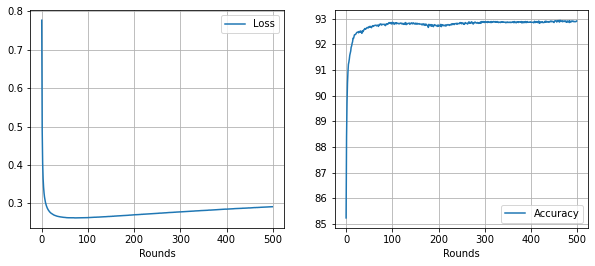

# ===== seed = 4912 ===== #
[Round 0]  Round Loss: 0.7790756458044052  Round Acc: 85.11
[Round 100]  Round Loss: 0.26345142476260663  Round Acc: 92.83
[Round 200]  Round Loss: 0.2704586512595415  Round Acc: 92.87
[Round 300]  Round Loss: 0.2779414511471987  Round Acc: 92.87
[Round 400]  Round Loss: 0.2850494047254324  Round Acc: 92.87
[Round 499]  Round Loss: 0.29131286695599556  Round Acc: 92.86


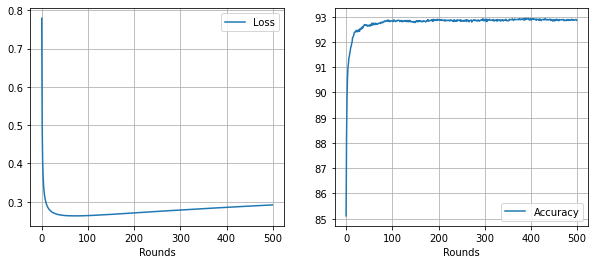

# ===== seed = 6140 ===== #
[Round 0]  Round Loss: 0.7840839433670044  Round Acc: 85.14
[Round 100]  Round Loss: 0.26283649891614913  Round Acc: 92.81
[Round 200]  Round Loss: 0.2699409941583872  Round Acc: 92.82
[Round 300]  Round Loss: 0.27757426008582115  Round Acc: 92.83
[Round 400]  Round Loss: 0.284752431884408  Round Acc: 92.94
[Round 499]  Round Loss: 0.2910395312309265  Round Acc: 92.92


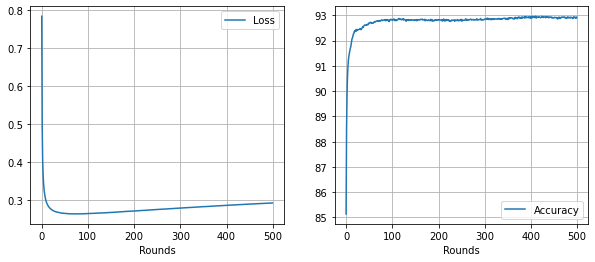

finished save


In [11]:
list_var = [1228, 1228*2, 1228*3, 1228*4, 1228*5]
param_tensor = torch.tensor([])

for var in list_var:
    print(f"# ===== seed = {var} ===== #")
    seed = var
    np.random.seed(seed)
    torch.manual_seed(seed)

    parser = argparse.ArgumentParser()
    args = parser.parse_args("")

    args.exp_name = 'mining'

    args.num_epochs = 5
    args.num_rounds = 500
    args.num_clients = 3
    args.lr = 0.0001

    args.batch_size = 100

    args.NET_PATH = ''
    args.INIT_PATH = f'FL(mining_data)/initialize_weight.pth'


    train_set_list = data_split(args)
    partition = {'train':train_set_list, 'test':test_dataset}
    round_loss, round_acc, round_list, param_data = experiment(partition, args)
    
    plot_loss(round_loss, round_acc)
    rounded_param = add_round(param_data, round_list, args)
    param_tensor = torch.cat([param_tensor, rounded_param], dim=0)
    
save_param_for_mining(param_tensor, args)